## **Preparation**

- mengunduh FastText dengan format .zip
- mengekstrak file FastText yang masih dalam format .zip
- mengimpor *library* yang diperlukan
- membaca data latih
- mencetak informasi dari data latih
- menecetak label dari data latih

In [1]:
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip

--2023-03-27 07:38:32--  https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.227.219.59, 13.227.219.33, 13.227.219.70, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.227.219.59|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 681808098 (650M) [application/zip]
Saving to: ‘wiki-news-300d-1M.vec.zip’

wiki-news-300d-1M.v 100%[===================>] 650.22M   219MB/s    in 3.0s    

2023-03-27 07:38:35 (219 MB/s) - ‘wiki-news-300d-1M.vec.zip’ saved [681808098/681808098]



In [2]:
!unzip wiki-news-300d-1M.vec.zip

Archive:  wiki-news-300d-1M.vec.zip
  inflating: wiki-news-300d-1M.vec   


In [3]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
import re
import tqdm

In [4]:
data = pd.read_csv("/kaggle/input/jigsaw-toxic-comment-classification-challenge/train.csv.zip")
data.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             159571 non-null  object
 1   comment_text   159571 non-null  object
 2   toxic          159571 non-null  int64 
 3   severe_toxic   159571 non-null  int64 
 4   obscene        159571 non-null  int64 
 5   threat         159571 non-null  int64 
 6   insult         159571 non-null  int64 
 7   identity_hate  159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


In [6]:
categories = list(data.columns.values)
categories = categories[2:]
print(categories)

['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']


## **EDA**

- mencetak tabel distribusi label data latih
- memvisualisasikan distribusi label 
- mencetak jumlah data yang memiliki multilabel
- memvisualisasikan nilai korelasi antar label menggunakan *heatmap*
- memvisualisasikan *Wordcloud*

In [7]:
counts = []
for category in categories:
    counts.append((category, data[category].sum()))
df_stats = pd.DataFrame(counts, columns=['category', 'number of comments'])
df_stats

,category,number of comments
0,toxic,15294
1,severe_toxic,1595
2,obscene,8449
3,threat,478
4,insult,7877
5,identity_hate,1405


Text(0, 0.5, 'Types of comments')

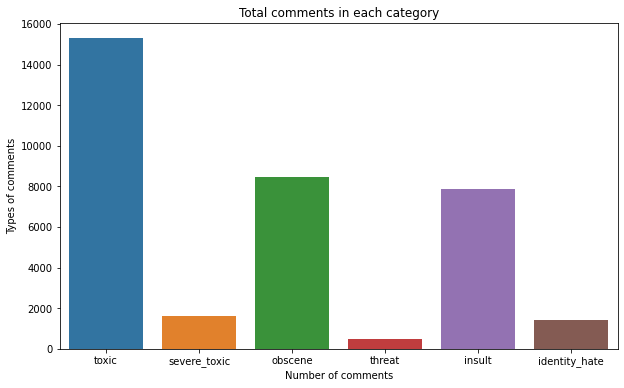

In [8]:
plt.figure(figsize=(10,6))
sns.barplot(x = list(data.columns[2:]), y= list(data.iloc[:,2:].sum()))
plt.title('Total comments in each category')
plt.xlabel('Number of comments')
plt.ylabel('Types of comments')

In [9]:
count = 0
for i in range(len(data)):
    n = data.iloc[i,2:].sum()
    if n > 1:
        count = count + 1
    
print('Total multi-labeled comments:',count)

Total multi-labeled comments: 9865


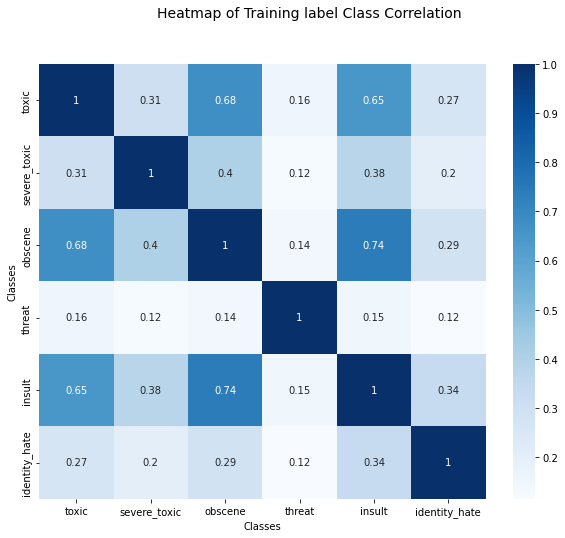

In [10]:
fig = plt.figure(figsize = (10,8))
sns.heatmap(data.corr(), annot=True,cmap="Blues")
plt.suptitle('Heatmap of Training label Class Correlation',size = 14)
plt.xlabel("Classes")
plt.ylabel("Classes")
plt.show()

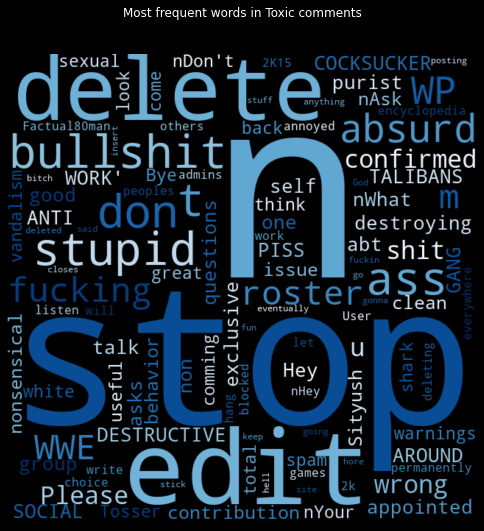

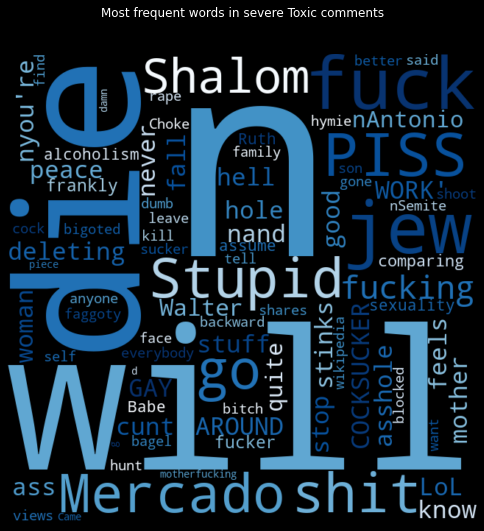

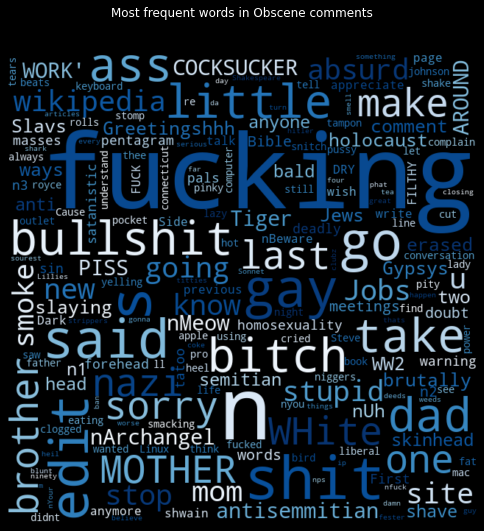

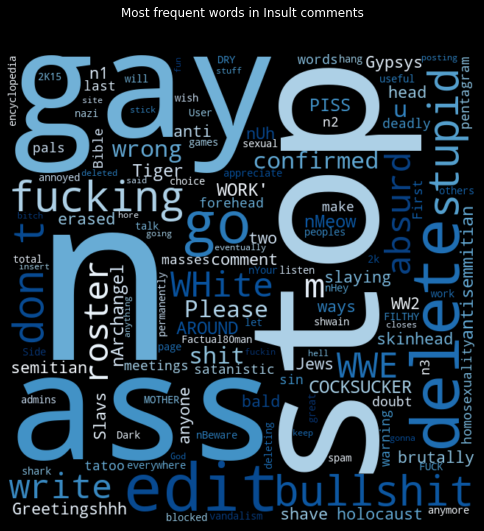

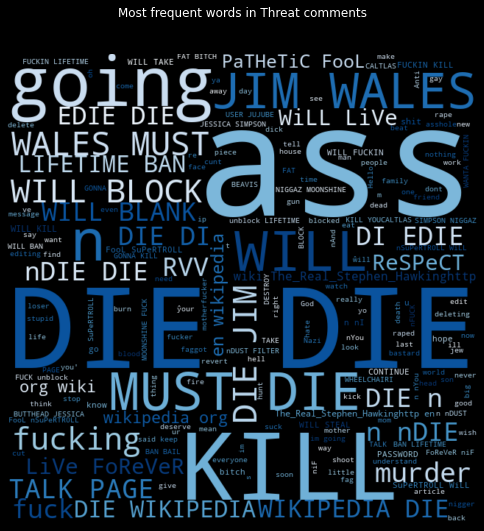

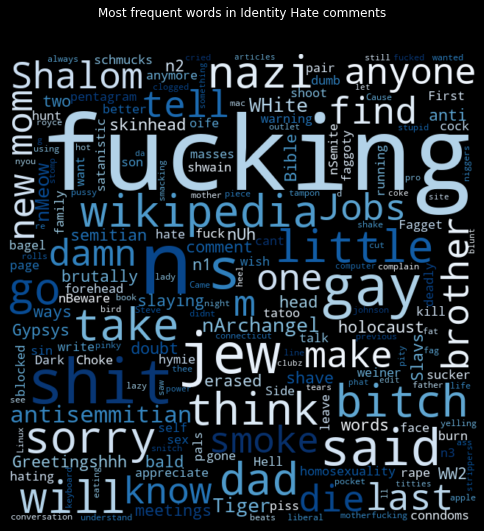

In [11]:
def word_plot(column,text):
    
    comments = data['comment_text'].loc[column == 1].values     # sort by toxicity
    
    word_cloud = WordCloud( width = 640, height = 640, background_color = 'black',
                stopwords = STOPWORDS).generate(str(comments))     # stopwords are a,an,the
    
    fig = plt.figure( figsize = (15, 7), facecolor = 'k', edgecolor = 'k')
    plt.subplot()
    plt.imshow(word_cloud.recolor(colormap="Blues"), interpolation = 'bilinear')
    plt.suptitle("Most frequent words in " +  text , y = 1.06,color = "white")
    plt.tight_layout(pad = 0)
    plt.axis('off')
    plt.show()

word_plot(data['toxic'], "Toxic comments")
word_plot(data['severe_toxic'],"severe Toxic comments")
word_plot(data['obscene'],"Obscene comments")
word_plot(data['insult'],"Insult comments")
word_plot(data['threat'],"Threat comments")
word_plot(data['identity_hate'],"Identity Hate comments")

## **Data Cleaning**

- membuat kolom baru bernama total_classes yang berisi jumlah label dari masing masing data yang memiliki lebih dari satu label
- melakukan proses *data cleaning* dengan mengubah huruf kapital menjadi huruf kecil, mengganti *non-breaking space* dengan *regular space*, menghilangkan ekstra *space* pada tabel, menghabus *hyperlink* dan menghapus karakter khusus. 

In [12]:
# creating new column named "total_classes" which will show total no. of classes comment belongs to

data["total_classes"] = data.iloc[:,2:].apply(lambda x: sum(x), axis=1)   
data

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,total_classes
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
159566,ffe987279560d7ff,""":::::And for the second time of asking, when ...",0,0,0,0,0,0,0
159567,ffea4adeee384e90,You should be ashamed of yourself \n\nThat is ...,0,0,0,0,0,0,0
159568,ffee36eab5c267c9,"Spitzer \n\nUmm, theres no actual article for ...",0,0,0,0,0,0,0
159569,fff125370e4aaaf3,And it looks like it was actually you who put ...,0,0,0,0,0,0,0


In [13]:
# Conerting all strings into lower case
data["comment_text"] = data["comment_text"].str.lower()

# Replacing non-breaking space with a regular space 
data["comment_text"] = data["comment_text"].str.replace("\xa0", " ", regex=False).str.split().str.join(" ")

# Removing extra spaces in text
data["comment_text"] = data["comment_text"].map(lambda x: re.sub(r"\s\s+", " ",x))

# Removing Hyperlinks from text
data["comment_text"] = data["comment_text"].map(lambda x: re.sub(r"https?://\S+|www\.\S+","",x))

# Removing Special characters 
data["comment_text"] = data["comment_text"].map(lambda x: re.sub(r"[^a-zA-Z0-9\s\"\',:;?!.()]", " ",x))

## **Data Training**

- mengimpor *library* yang diperlukan
- membaca data uji tanpa label dan label data uji yang kemudian digabungkan menjadi satu
- menghapus semua data yang memiliki nilai -1 pada kolom label
- memisahkan kolom text dengan kolom label dari data latih dan data uji
- mendefinisikan nilai untuk parameter
- proses tokenisasi dari data text yang sudah dipisahkan dengan labelnya
- membuat fungsi untuk membaca FastText
- membaca FastText yang sudah diunduh tadi 
- mencetak dimensi vektor dari FastTex
- membuat arsitektur dari model
- mencetak *summary* dari model yang sudah didefinisikan
- melakukan pelatihan model dengan parameter yang sudah ditentukan


In [14]:
import gensim.models.keyedvectors as word2vec
import pandas as pd
import gc
from keras_preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import CuDNNLSTM
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tqdm import tqdm

In [15]:
train = data
test = pd.read_csv("/kaggle/input/jigsaw-toxic-comment-classification-challenge/test.csv.zip")
test_labels = pd.read_csv("../input/jigsaw-toxic-comment-classification-challenge/test_labels.csv.zip")
test = test.merge(test_labels, on="id")

In [16]:
# Drop all rows with -1 in label values
drop_idxs = test[
    (test.toxic == -1) | (test.severe_toxic == -1) | (test.obscene == -1) | 
    (test.threat == -1) | (test.insult == -1) | (test.identity_hate == -1)
].index
test = test.drop(drop_idxs, axis="rows")

In [17]:
list_sentences_train = train["comment_text"]
list_sentences_test = test["comment_text"]
y_train = train[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].values
y_test = test[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].values

In [18]:
embed_size = 100
max_features = 20000
max_len = 200

In [19]:
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(list_sentences_train))
list_tokenized_train = tokenizer.texts_to_sequences(list_sentences_train)
list_tokenized_test = tokenizer.texts_to_sequences(list_sentences_test)
X_train = pad_sequences(list_tokenized_train, maxlen=max_len)
X_test = pad_sequences(list_tokenized_test, maxlen=max_len)

In [20]:
def loadEmbeddingMatrix(typeToLoad):
        # load different embedding file from Kaggle depending on which embedding 
        # matrix we are going to experiment with

        EMBEDDING_FILE='/kaggle/working/wiki-news-300d-1M.vec'
        embed_size = 300
        embeddings_index = dict()
        # Transfer the embedding weights into a dictionary by iterating through every line of the file.
        f = open(EMBEDDING_FILE)
        for line in tqdm(f):
            try:
                # split up line into an indexed array
                values = line.split()
                # first index is word
                word = values[0]
                # store the rest of the values in the array as a new array
                coefs = np.asarray(values[1:], dtype='float32')
                # ignore values without headers as word
                if len(coefs)==300:
                    embeddings_index[word] = coefs #300 dimension
                else:
                    continue
            except:
                # split up line into an indexed array
                values = line.split()
                # first index is word or sometimes the second as well
                word = values[1]
                # store the rest of the values in the array as a new array
                coefs = np.asarray(values[2:], dtype='float32')
                print(values[:2])
                print(len(coefs))
                embeddings_index[word] = coefs #300 dimension
        f.close()
        print('Loaded %s word vectors.' % len(embeddings_index))
        #return embeddings_index
            
        gc.collect()
        # We get the mean and standard deviation of the embedding weights so that we could maintain the 
        # same statistics for the rest of our own random generated weights. 
        all_embs = np.stack(embeddings_index.values())
        #np.stack(list(embeddings_index.values()))
        emb_mean, emb_std = all_embs.mean(), all_embs.std()
        
        nb_words = len(tokenizer.word_index)
        # We are going to set the embedding size to the pretrained dimension as we are replicating it.
        # the size will be Number of Words in Vocab X Embedding Size
        embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
        gc.collect()

        # With the newly created embedding matrix, we'll fill it up with the words that we have in both 
        # our own dictionary and loaded pretrained embedding. 
        embeddedCount = 0
        for word, i in tokenizer.word_index.items():
            i-=1
            # then we see if this word is in glove's dictionary, if yes, get the corresponding weights
            embedding_vector = embeddings_index.get(word)
            # and store inside the embedding matrix that we will train later on.
            if embedding_vector is not None: 
                embedding_matrix[i] = embedding_vector
                embeddedCount+=1
        print('total embedded:',embeddedCount,'common words')
        
        del(embeddings_index)
        gc.collect()
        
        # finally, return the embedding matrix
        return embedding_matrix

In [21]:
embedding_matrix = loadEmbeddingMatrix('fasttext')

999995it [00:54, 18234.38it/s]
/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3552: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


Loaded 999994 word vectors.
total embedded: 85984 common words


In [22]:
embedding_matrix.shape

(190147, 300)

In [23]:
model = Sequential()
model.add(Embedding(len(tokenizer.word_index), embedding_matrix.shape[1], 
                  weights=[embedding_matrix], trainable=True, input_shape=(max_len,)))
model.add(Bidirectional(CuDNNLSTM(64, return_sequences=True, name='lstm_layer')))
model.add(Dropout(0.1))
model.add(GlobalMaxPool1D())
model.add(Dropout(0.1))
model.add(Dense(50, activation="relu"))
model.add(Dropout(0.1))
model.add(Dense(6, activation="sigmoid"))
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=1e-4), metrics=['accuracy'])

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 200, 300)          57044100  
_________________________________________________________________
bidirectional (Bidirectional (None, 200, 128)          187392    
_________________________________________________________________
dropout (Dropout)            (None, 200, 128)          0         
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 50)                6450      
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0

In [25]:
batch_size = 32
epochs = 4
trace = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Epoch 1/4
4488/4488 [==============================] - 155s 34ms/step - loss: 0.1045 - accuracy: 0.8078 - val_loss: 0.0579 - val_accuracy: 0.9940
Epoch 2/4
4488/4488 [==============================] - 151s 34ms/step - loss: 0.0523 - accuracy: 0.9360 - val_loss: 0.0515 - val_accuracy: 0.9940
Epoch 3/4
4488/4488 [==============================] - 151s 34ms/step - loss: 0.0479 - accuracy: 0.9492 - val_loss: 0.0500 - val_accuracy: 0.9940
Epoch 4/4
4488/4488 [==============================] - 151s 34ms/step - loss: 0.0437 - accuracy: 0.9642 - val_loss: 0.0492 - val_accuracy: 0.9940


## Evaluation
- membuat visusalisasi dari nilai akurasi, *loss*, akurasi validasi, validasi *loss* yang dilatih menggunakan data latih
- mencetak nilai akurasi dan *loss* yang digunakan untuk prediksi menggunakan data uji
- mencetak hasil pengujian pada *text* asli

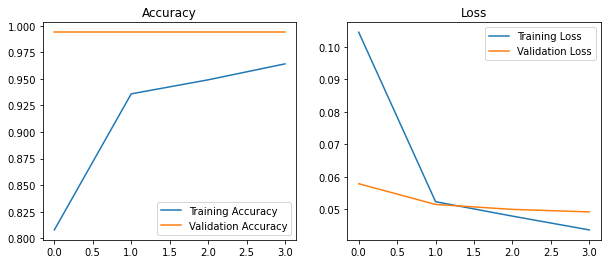

In [26]:
# extract the accuracy and loss from the history object
acc = trace.history['accuracy']
val_acc = trace.history['val_accuracy']
loss = trace.history['loss']
val_loss = trace.history['val_loss']

# create a figure and axes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

# plot the accuracy on the first axes
ax1.plot(acc, label='Training Accuracy')
ax1.plot(val_acc, label='Validation Accuracy')
ax1.set_title('Accuracy')
ax1.legend()

# plot the loss on the second axes
ax2.plot(loss, label='Training Loss')
ax2.plot(val_loss, label='Validation Loss')
ax2.set_title('Loss')
ax2.legend()

# show the plot
plt.show()

In [27]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)

2000/2000 [==============================] - 17s 9ms/step - loss: 0.0715 - accuracy: 0.9976
Test Loss: 0.07147739082574844
Test Accuracy: 0.9975616335868835


In [28]:
list_classes = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

i=2018
print(list_sentences_train[i])
print(dict(zip(list_classes, model.predict(X_train[i:i+1])[0])))
print('Actual Values:', train[list_classes].iloc[i].to_dict())

you are a gay homo. i hope you choke on your penis and die. i am sending a big bleck guy to jizz in your face.
{'toxic': 0.9742957, 'severe_toxic': 0.320108, 'obscene': 0.8160237, 'threat': 0.116544105, 'insult': 0.84721607, 'identity_hate': 0.28955218}
Actual Values: {'toxic': 1, 'severe_toxic': 0, 'obscene': 1, 'threat': 1, 'insult': 1, 'identity_hate': 1}


In [33]:
from sklearn.metrics import classification_report

# Use your trained model to make predictions on the test set
y_pred = model.predict(X_test)

# Convert predicted probabilities to binary predictions
y_pred_binary = (y_pred > 0.5).astype(int)

# Print the classification report
print(classification_report(y_test, y_pred_binary, target_names=list_classes, zero_division=1))

               precision    recall  f1-score   support

        toxic       0.58      0.82      0.68      6090
 severe_toxic       0.39      0.44      0.42       367
      obscene       0.66      0.76      0.71      3691
       threat       1.00      0.00      0.00       211
       insult       0.61      0.65      0.63      3427
identity_hate       1.00      0.00      0.00       712

    micro avg       0.60      0.70      0.65     14498
    macro avg       0.71      0.45      0.41     14498
 weighted avg       0.63      0.70      0.62     14498
  samples avg       0.94      0.97      0.91     14498

